In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
!pip install XlsxWriter

In [48]:
from cmath import sqrt
from tkinter import S
from matplotlib import pyplot
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import xlsxwriter
import seaborn as sns
import scipy.integrate as spi
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [72]:
wl_min = 380
wl_max = 780
wl_step = 1
wl_scale = np.arange(wl_min,wl_max+1,wl_step)
label_font_size=14
drawNumber = 100000 # Iteration Number
binValue = 50
input_FileName = "/content/drive/MyDrive/MC-Yılmaz/only_MC/2_3_6500K input format _FLUX_GENEL_4.xlsx"
rowvar = False

modelFunctionName = "Flux"
data_SheetName = "Data"
distributions_SheetName = "Distributions"
abs_or_rel="absolute"
write_to_txt = False
workbook = xlsxwriter.Workbook("/content/drive/MyDrive/MC-Yılmaz/only_MC/" + modelFunctionName+"output_"+str(drawNumber)+".xlsx")

XAxisName=""
url_head = "/content/drive/MyDrive/MC-Yılmaz/only_MC/"

In [50]:
def ReadFile(FileName):

    """
    English:

    --> The ReadFile function reads the input.xlsx file which includes input variables. There are one column for average and one column for standart deviation for
    -each input variable.

    --> For example, the format of the input.xlsx file should be as follows.

            1.column      2.column   3.column         4.column   5.column        . . . n.column
    1.row   Wave Lengths  Average 1  Standart Dev. 1  Average 2  Standart Dev. 2
    2.row      350          0.55      0.45*10^-5       0.7        0.1*10^-10
    .
    .
    .
    m.row


    --> After the format is set correctly, it assigns the values of the first column of the input excel file
    (except for the 1st row because it must be the header row) to the matrix_waveLengths variable.
    --> The size of matrix_waveLengths variable will be ==> Wave Length Number x 1. Their values will be like 350,351....
    --> The size of matrix_values variable will be ==> WaveLength Number  x DataNumber*2

    """
    # FileName can be "input_1.xlsx" or "input_2.xlsx"...

    # reading 1st column of input excel file
    df_wavelengths = pd.read_excel(FileName , sheet_name = data_SheetName , usecols = "A" , engine='openpyxl')

    # From the 2nd column (except the 1st column) it reads the input excel file.
    df_values = pd.read_excel(FileName , sheet_name = data_SheetName , index_col=0 , engine='openpyxl')

    df_distr = pd.read_excel(FileName , sheet_name = distributions_SheetName , engine = 'openpyxl')
    try:
        v_lambda = pd.read_excel(FileName, sheet_name="VLamda",index_col=0, engine = 'openpyxl')
    except:
        v_lambda = pd.DataFrame(0, index=[0], columns=[0])

    matrix_v_lambda = np.array(v_lambda)

    # we need to numpy.array as type.
    d = list(df_wavelengths.columns)
    XAxisName = d[0]
    matrix_waveLengths = np.array(df_wavelengths)
    matrix_values = np.array(df_values)
    matrix_distr = np.array(df_distr)

    #matrix_v_lambda = np.array(0)
    return matrix_waveLengths , matrix_values , matrix_distr, XAxisName, matrix_v_lambda


In [51]:
def getTranspose(matrix):

    """
    English:

    --> matrix must be numpy.array.

    --> We are getting transpose of matrix. Because we need to get the transpose of the matrix for some "for" loops.

    """
    return matrix.T

In [52]:
def checkIsEqual(mean_array , std_array):

    checkMean = np.all(mean_array == mean_array[0])
    checkStd = np.all(std_array == std_array[0])

    return checkMean , checkStd

In [53]:
def findDimensions(matrix):

    """
    English:

    --> This function takes matrix as parameter. Returns the row and column numbers of the matrix.

    --> Returning rowNumber and colNumber, our goal is to find Wavelength number and DataNumber with this parameter.

    """

    rowNum = len(matrix)
    colNum = len(matrix[0])
    return rowNum,colNum

In [54]:
def drawValues(Mean , Stddev , Draws=1000 , DoF = 1 , Type = "normal"):

    # uniform and rectangular have same distributions

    if type (Mean) != np.ndarray: # checks if an array of distributions or single distribution is needed

        if Type == "normal":
            nxi = stats.norm.rvs (loc=Mean, scale=Stddev, size=Draws)
            return(nxi)

        if Type == "T":
            txi=stats.t.rvs (loc=Mean, scale=Stddev, df=DoF, size= Draws)
            return(txi)

        if Type == "uniform" or Type == "rectangular":
            low_value = Mean - Stddev*sqrt(3)
            high_value = Mean + Stddev*sqrt(3)
            uxi = np.random.uniform(low=low_value, high=high_value, size=Draws)

            return(uxi)

        if Type == "triangle":
            trxi=stats.triang.rvs(loc=Mean, scale=Stddev, c=DoF, size=Draws)
            return (trxi)

        if Type == "gamma":
            gxi = stats.gamma.rvs(loc=(Mean / Stddev)^2, scale=Stddev^2 / Mean, c=DoF, size=Draws)
            return(gxi)

    else:
        result=np.zeros([len(Mean),Draws])

        for i in range (len(Mean)):

            if Type == "normal":
                result[i]= stats.norm.rvs (loc=Mean[i], scale=abs(Stddev[i]), size=Draws)

            if Type == "T":
                result[i]= stats.t.rvs (loc=Mean[i] , scale=abs(Stddev[i]), df=DoF, size= Draws)

            if Type == "uniform" or Type == "rectangular":
                low_value = Mean[i] - Stddev[i]*sqrt(3)
                high_value = Mean[i] + Stddev[i]*sqrt(3)
                result[i] = np.random.uniform(low=low_value, high=high_value, size=Draws)

            if Type == "triangle":
                result[i]=stats.triang.rvs(loc=Mean[i], scale=abs(Stddev[i]), c=DoF, size=Draws)

            if Type == "gamma":
                result[i] = stats.gamma.rvs(loc=(Mean[i] / Stddev[i])^2, scale=Stddev[i]^2 / Mean[i], c=DoF, size=Draws)

        return (result)

In [55]:
def sumMC(InputValues, Coverage=0.95, printOutput=False):

    #Sorting of the input values
    Ys=sorted(InputValues)

    #Calculating the number of draws
    Ylen=len(InputValues)

    # Calculating the number of draws covering the given coverage
    # q = p*M -> must integer , Ylen = M (iteration number) , coverage = p (0.95)
    q=int(Ylen*Coverage)

    #Calculating the draw representing the lower coverage interval boundary
    # r = 0.5 * (M-(p*M)) -> must integer
    r= int(0.5*(Ylen-q))

    #Calculating the mean of the input values
    ymean=np.mean(InputValues)

    #Calculating standard deviation of the input values as absolute standard uncertainty
    yunc=np.std(InputValues)

    #Summarizing mean and uncertainty
    values=[ymean,yunc]

    #Calculating the values of the draws for olwer and upper boundary of the coverage interval
    # sorted list = Ys , r = 0.5 * (M-(p*M))
    ylow=Ys[r]
    yhigh=Ys[r+q]

    #Summarizing the coverage intervall
    interval=[ylow,yhigh]

    #Summarizing the total output
    output=[values,interval]

    #Printing the output values
    if printOutput==True:
        print('mean;'+str(values[0]))
        print('standard deviation:'+str(values[1]))
        print("ylow: ",str(ylow), " yhigh: ", str(yhigh))
        print(str(Coverage*100)+'% interval:'+str (interval))
    # Returns the output values
    return output

In [56]:
#output2
def calculateMeanStdMC(matrix_Values , matrix_Distr , Data_Number , WaveLength_Number):

    """
    English:

    --> This function takes matrix_Values , Data_Number and WaveLength_Number as parameters.
    matrix_Values parameter is transpose of matrix of ReadFile function and given as a parameter to the this function.
    Transpose operation is required. Because the rows of our matrix should have mean and standard deviation values, and the column number should be as much as the number of wavelengths.
    For Exemple:
        matrix.Values:
                    1.column(350)       2.column(351)         3.column ...    WaveLength_Number. column
            1.row   average 1       average 1
            2.row   Standart Dev.1  Standart Dev.1
            3.row   average 2       average 2
            .
            .
            .
            Data_Number*2.row

    So the size of matrix_Values parameter should be ==> DataNumber*2 x WaveLength Number. It is used accordingly in our loops.

    --> The main purpose of this function is to prepare the output2 of the output Excel file.

    --> Iterations of the data are taken separately for each wavelength, and the mean and standard deviation values of the iteration matrices are calculated.
        For Example:

                 First Data(A1)                     Second Data(A2)   . . .DataNumber.Data(An)

                 A1,350,first iteration             A2,350,first iteration
                 A1,350,second iteration            A2,350,second iteration
                 .
        350:     .
                 .
                 A1,350, drawNumber. iteration      A2,350,drawNumber. iteration
                ------------------------------      ---------------------------
                 A1,350,mean --> mean_matrix[0][0]  A2,350,mean --> mean_matrix[0][1]
                 A1,350,std  --> std_matrix[0][0]   A2,350,std  --> std_matrix[0][1]

         .
         .
         .

    Lastest Wave Length: . . .

    --> Calculated values are kept in mean_matrix and std_matrix variables.
    The dimensions of mean_matrix and std_matrix are ==> WaveLength_Number x DataNumber.

    -->  It is used in the drawValues and sumMC functions written by PTB in the this function.


    Changed functionality:
        For the Data A7 to A13 there is only one set of "drawNumber" results generated.
        A7 to A13 do not change over wavelength in the provided input data.
        If one measurement for each quantity A7 to A13 determines the value used for each wavelength, the expected value of the distribution is the same.
        This results in complete correlation over wavelength, meaning the generated random number has to change over each iteration, but has to stay the same for each wavelength.

    """

    result_list = [] # We use the DrawValues function to hold the returns. and we send to calculateOutputwithFormulMC function.

    mean_matrix   = [[0 for j in range(Data_Number)] for i in range(WaveLength_Number)]
    std_matrix    = [[0 for j in range(Data_Number)] for i in range(WaveLength_Number)]

    for i in range(0,Data_Number*2,2): # matrix_Values's row number equals Data_Number*2

        data_count = int(((i+1)/2)+1)

        check_mean , check_std = checkIsEqual(matrix_Values[i] , matrix_Values[i+1])
        # if checkIsEqual == False --> normal
        # if checkisEqual == True  --> uniform

        if check_mean & check_std == False:
            result = drawValues(matrix_Values[i] , matrix_Values[i+1] , drawNumber , DoF = 1 , Type = matrix_Distr[data_count-1])
            result_list.append(result)

            for j in range(0,WaveLength_Number):

                output = sumMC(result[j] , Coverage = 0.95 , printOutput= False)
                mean_matrix[j][data_count-1] = output[0][0]
                std_matrix[j][data_count-1] = output[0][1]

        elif check_mean & check_std == True:
            result = drawValues(matrix_Values[i,0] , matrix_Values[i+1,0] , drawNumber, DoF = 1 , Type = matrix_Distr[data_count-1])
            temp=[]

            for k in range(WaveLength_Number):
                temp.append(result)

            temp_np=np.array(temp)
            result_list.append(temp_np)

        # We calculated mean and standart dev. of draws(Iteration Number) for each wave length
            for j in range(0,WaveLength_Number):

                mean_matrix[j][data_count-1] = np.full_like(output[0][0] , matrix_Values[i,0])
                std_matrix[j][data_count-1] = np.full_like(output[0][1] , matrix_Values[i+1,0])

    return result_list , mean_matrix , std_matrix

In [57]:
#output1
def calculateOutputwithFormulaMC(result_list , Data_Number , WaveLength_Number , modelFunctionName, matrix_v_lambda, mean_matrix):

    """
   English:
   --> The main purpose of this function is to prepare the "output1" result of the "output" excel file for Monte Carlo iteration results.

   --> This function takes "result_list" , "Data_Number" and "WaveLength_Number" as parameters.

   --> "result_list": It corresponds to the "result_list" in the return of the "calculateMeanStdMC" function.
       The length of the "result_list" is expected to be as much as the "DataNumber" number.

   --> The values produced as a result of iteration of each data are used in the formula function of the ones belonging to the same index and the result is obtained
   and this is applied for each wavelength.

   For Example:
        drawNumber(iterasyon number) = 4
        Data_Number = 2
        WaveLength_Number = 3
        formula equation : I = A1+ A2

         A1          A2
        A1,350,1   A2,350,1 -->    I350,1 = A1,350,1 + A2,350,1
        A1,350,2   A2,350,2 -->    I350,2 = A1,350,2 + A2,350,2
  350:  A1,350,3   A2,350,3 -->    I350,3 = A1,350,3 + A2,350,3
        A1,350,4   A2,350,4 -->    I350,4 = A1,350,4 + A2,350,4
                               ------------------------------
                                   I350,mean , I350,std

        A1          A2
        A1,351,1   A2,351,1 --> I351,1 = A1,351,1 + A2,351,1
        A1,351,2   A2,351,2 --> I351,2 = A1,351,2 + A2,351,2
  351:  A1,351,3   A2,351,3 --> I351,3 = A1,351,3 + A2,351,3
        A1,351,4   A2,351,4 --> I351,4 = A1,351,4 + A2,351,4
                               ------------------------------
                                   I351,mean , I351,std


        A1          A2
        A1,352,1   A2,352,1 --> I352,1 = A1,352,1 + A2,352,1
        A1,352,2   A2,352,2 --> I352,2 = A1,352,2 + A2,352,2
  352:  A1,352,3   A2,352,3 --> I352,3 = A1,352,3 + A2,352,3
        A1,352,4   A2,352,4 --> I352,4 = A1,352,4 + A2,352,4
                               ------------------------------
                                   I352,mean , I352,std


     --> "output_matrix" keeps the mean and standard deviation values that we have calculated for each wavelength.
         The size of "output_matrix" is ==> WaveLength_Number x 2.

   --> "draw_matrix" is the creation of a matrix from the common index elements of random values as much as the number of iterations produced for each data.
   That is, it is rendered like draw_matrix[0]= [A1,350.1 , A2,350.1].
   size of "draw_matrix": drawNumber x Data_Number


   Changed functionality:

   --> "mc_values" is added as a matrix for keeping the monte carlo results after using the drawn values in the formula.
   The "draw_matrix" values are used in the "formula" so for each wavelength there are "iteration_number" results of the formula.
   This are required for calculation correlations.

   """
    iteration_mean_sum_matrix = np.zeros(drawNumber)
    output_matrix = [[0 for j in range(2)] for i in range(WaveLength_Number)]
    draw_matrix   = [[0 for j in range(Data_Number)] for i in range(drawNumber)]
    mc_Values = np.zeros((drawNumber, WaveLength_Number))

    # We calculated formul result's mean and standart dev. of a wave length until draws number(iteration number.)
    for k in range(0,WaveLength_Number):

        for i in range(0,drawNumber):

            for j in range(0,Data_Number):

                temp_result = result_list[j]
                # We create the inside of the draw_matrix.
                draw_matrix[i][j] = temp_result[k][i]

        # The created draw_matrix is sent to the formula and the formula is written in its place with the necessary indexes, the result is calculated and thrown into the output_matrix.
        output_matrix[k][0] , output_matrix[k][1] , mc_Values[:,k], iteration_mean_sum_matrix = formula(iteration_mean_sum_matrix, draw_matrix , modelFunctionName, matrix_v_lambda, k, mean_matrix, WaveLength_Number)

    # for write to text -> write_to_txt=True (default False)
    if write_to_txt:
        for i in range(0, drawNumber):
            with open(modelFunctionName+"_"+str(i)+".txt", "w") as f:
                for j in range(0, WaveLength_Number):
                    line = str(j*wl_scale+wl_min)+ "\t" + str(mc_Values[i][j])
                    f.write(line)
                    if j !=WaveLength_Number-1:
                        f.write('\n')
                f.close()

    output = sumMC(iteration_mean_sum_matrix , Coverage = 0.95 , printOutput= False)
    print("mean: ", output[0][0])
    print("std. dev: ", output[0][1])
    print("iteration matrix total mean: ", np.mean(iteration_mean_sum_matrix))
    print("\niteration sum matrix std.dev: ", np.std(iteration_mean_sum_matrix))
    return output_matrix , mc_Values, np.mean(iteration_mean_sum_matrix), np.std(iteration_mean_sum_matrix)


In [58]:
def formula(iteration_mean_sum_matrix, draw_matrix , modelFunctionName, matrix_v_lambda, wavelength_num, mean_matrix, WaveLength_Number):

    """
    English:
     --> The main purpose of this function is to calculate and return the mean and standard deviation values by formulating them with
     the values of the draw_matrix variable created separately for each wavelength.
    --> This function takes the draw_matrix parameter. The formula function is called by the calculateOutputwithFormulaMC function.
    draw_matrix corresponds to the draw_matrix matrix in this function.
    The size of draw_matrix should be ==> drawNumber x DataNumber.

    --> Draw_matrix is created for each wavelength. It is calculated by putting the correct places in the formula with draw_matrix.
     For Example:
        draw_matrix[0] = [A1,350,1 , A2,350,1]
        draw_matrix[1] = [A1,350,2 , A2,350,2]
        .
        .
        .
        draw_matrix[drawNumber - 1 ] = [A1,350,drawNumber , A2,350,DrawNumber]



    Changed functionality:
        The complete output_list is returned as a result.
        The list is requiered for correlation analysis.
        By calculating mean and std immediately all information about correlations included in the random numbers is lost.

    """
    # draw_matrix --> drawNumber x Data Number size
    if modelFunctionName == 'responsivity':
        integral1 = 0
        integral2 = 0
        d_lambda = 1

        for i in range(0, WaveLength_Number):
            v_lambda = matrix_v_lambda[i][0]
            X1 = mean_matrix[i][0]
            X2 = mean_matrix[i][1]
            integral1 += (X1*X2*d_lambda)
            integral2 += (v_lambda*X2*d_lambda)

    if modelFunctionName == 'f1prime':
        integral1 = 0
        integral2 = 0
        d_lambda = 1
        for i in range(0, WaveLength_Number):

            v_lambda = matrix_v_lambda[i][0]
            X1 = mean_matrix[i][0]
            X2 = mean_matrix[i][1]
            integral1 += (X2*v_lambda*d_lambda)
            integral2 += (X2*X1*d_lambda)

    formula = 0.0

    output_list = []
    # print("---------draw matrix---------\n", draw_matrix[0])
    for i in range(0,len(draw_matrix)):

        # if your data number is not equal to 13, it will calculate 0 for the output1 result. You should define a formula with an if condition for your data set.
        if len(draw_matrix[0]) == 13 and modelFunctionName == "tayfsal":

            first_Transaction  = (draw_matrix[i][0]+draw_matrix[i][5]+draw_matrix[i][6]+draw_matrix[i][7]+draw_matrix[i][8]+draw_matrix[i][9]+draw_matrix[i][10]+draw_matrix[i][11]+draw_matrix[i][12])/draw_matrix[i][2]
            second_Transaction = (draw_matrix[i][1]+draw_matrix[i][5]+draw_matrix[i][6]+draw_matrix[i][7]+draw_matrix[i][8]+draw_matrix[i][9]+draw_matrix[i][10]+draw_matrix[i][11]+draw_matrix[i][12])/draw_matrix[i][3]
            formula = (first_Transaction/second_Transaction)*draw_matrix[i][4]

        elif len(draw_matrix[0]) == 12 and modelFunctionName == "article":

            formula = (draw_matrix[i][0]/draw_matrix[i][1])*draw_matrix[i][2]*(draw_matrix[i][3]*draw_matrix[i][4]*draw_matrix[i][5]*draw_matrix[i][6]*draw_matrix[i][7]*draw_matrix[i][8]*draw_matrix[i][9]*draw_matrix[i][10]*draw_matrix[i][11])

        elif len(draw_matrix[0]) == 11 and modelFunctionName == "ADO":

            #formula = draw_matrix[i][0]*draw_matrix[i][1] + draw_matrix[i][2]
            formula = 100*((draw_matrix[i][0] - ((draw_matrix[i][2]-draw_matrix[i][3]) / draw_matrix[i][5]))/((draw_matrix[i][2]-draw_matrix[i][3])/draw_matrix[i][5]))

        elif len(draw_matrix[0]) == 13 and (modelFunctionName == "HORTI" or modelFunctionName == "radyometrik_guc" or modelFunctionName == "Flux"):
            formula = (draw_matrix[i][0]-draw_matrix[i][1])*(draw_matrix[i][5]/draw_matrix[i][2])*(draw_matrix[i][3]/draw_matrix[i][4])*(1-draw_matrix[i][6]-draw_matrix[i][7]-draw_matrix[i][8]-draw_matrix[i][9]-draw_matrix[i][10]-draw_matrix[i][11]-draw_matrix[i][12])

            if modelFunctionName == "Flux":
                km = 683
                d_lambda = 1
                v_lambda = matrix_v_lambda[wavelength_num][0]
                formula *= km*d_lambda*v_lambda
        elif len(draw_matrix[0]) == 14 and modelFunctionName == "PPF":

            formula = 0.00835942*(draw_matrix[i][0]-draw_matrix[i][1])*(draw_matrix[i][5]/draw_matrix[i][2])*(draw_matrix[i][3]/draw_matrix[i][4])*(1-draw_matrix[i][6]-draw_matrix[i][7]-draw_matrix[i][8]-draw_matrix[i][9]-draw_matrix[i][10]-draw_matrix[i][11]-draw_matrix[i][12])*(draw_matrix[i][13])

        elif modelFunctionName=="responsivity" and len(draw_matrix[0]) == 4:
            km = 683
            formula = (draw_matrix[i][2]*draw_matrix[i][3]*integral1)/(km*integral2)

        elif modelFunctionName=="f1prime" and len(draw_matrix[0]) == 2:
            d_lambda = 1
            formula = draw_matrix[i][0]*(integral1/integral2)

        output_list.append(formula)
        iteration_mean_sum_matrix[i] += formula
    # calculated mean and standart dev. of a wave length .
    # to access correlations the monte carlo results, without calculation of mean and standarddev has to be preserved
    # 2k icin np.std(output_list)*2 yapılmalı

    return np.mean(output_list), np.std(output_list), output_list, iteration_mean_sum_matrix


In [59]:
def writeExcel(sensCoefArr, output_matrix , mean_matrix , std_matrix , Data_Number , WaveLength_Number , matrix_WaveLengths , modelFunctionName, mean_iteraion_sum, std_iteration_sum):

    """

    English:

    --> The function takes output_matrix , mean_matrix , std_matrix , Data_Number , WaveLength_Number and matrix_WaveLengths as parameters.

    output_matrix:calculateOutputwithFormulaMC corresponds to the returned matrix of the function and expects it.

    mean_matrix , std_matrix: corresponds to the returned mean_matrix and std_matrix matrices of the calculateMeanStdMC function and expects them.

    WaveLength_Number: It corresponds to 1 minus the number of lines of the Excel file. Or it is equal to the returned Column Number of the findDimensions function and is expected.

    matrix_WaveLengths: Corresponds to the matrix_WaveLengths returned from the ReadFile function.

    --> The results produced as a result of Monte Carlo are written to Excel output_drawNumber.xlsx file.

    """

    worksheet_formul_output = workbook.add_worksheet("output1")
    worksheet_mean_std_output = workbook.add_worksheet("output2")
    worksheet_sensitivity_coef_output = workbook.add_worksheet("sensitivity coef")

    worksheet_mean_std_output.write(0,0,"Wave Lengths")
    worksheet_sensitivity_coef_output.write(0,0,"Wave Lengths")
    worksheet_formul_output.write(0,0,"Iteration Number")
    worksheet_formul_output.write(0,1,""+str(drawNumber))
    worksheet_formul_output.write(1,0,"Wave Lengths")
    worksheet_formul_output.write(1,1,"Mean")
    worksheet_formul_output.write(1,2,"Std_Dev_1k")

    for i in range(1,WaveLength_Number+1):
        worksheet_mean_std_output.write(i,0,matrix_WaveLengths[i-1])
        worksheet_formul_output.write(i+1,0,matrix_WaveLengths[i-1])
        worksheet_sensitivity_coef_output.write(i,0,matrix_WaveLengths[i-1])

    for i in range(1,WaveLength_Number+1):

        for j in range(0,Data_Number):

            # we are controling;is it first row or not ? true : false
            if i - 1 == 0:

                # j == 0 --> column: 1 , 2 j==1 --> column: 3 ,4  j==2 --> column: 5 , 6
                worksheet_mean_std_output.write(i-1,2*j+1,"mean"+str(j+1))
                worksheet_mean_std_output.write(i-1,2*j+2,"std"+str(j+1))
                worksheet_sensitivity_coef_output.write(i-1,j+1,"sensitivity coef "+str(j+1))

            worksheet_mean_std_output.write(i,2*j+1,mean_matrix[i-1][j])
            worksheet_mean_std_output.write(i,2*j+2,std_matrix[i-1][j])

            worksheet_sensitivity_coef_output.write(i,j+1,sensCoefArr[i-1][j])

        worksheet_formul_output.write(i+1 , 1 , output_matrix[i-1][0]) # row --> 0 2 4
        worksheet_formul_output.write(i+1 , 2 , output_matrix[i-1][1]) # row --> 1 3 5

    worksheet_formul_output.write(1,4,"Toplam Mean")
    worksheet_formul_output.write(2,4,'=SUM(B3:B'+str(WaveLength_Number+2)+')')

    worksheet_formul_output.write(1,5,"Topkare STD Abs")
    worksheet_formul_output.write(2,5, '=SQRT(SUMSQ(C3:C'+str(WaveLength_Number+2)+'))')

    worksheet_formul_output.write(1,6,"Topkare STD Rel")
    worksheet_formul_output.write(2,6,"=(F3/E3)*100")

    worksheet_formul_output.write(4, 4, "From Iteration")
    worksheet_formul_output.write(5, 4, mean_iteraion_sum)
    worksheet_formul_output.write(5, 5, std_iteration_sum)
    worksheet_formul_output.write(5 ,6,"=(F6/E3)*100")

    print("\nWriting is finished")
    # workbook.close()

In [60]:
def correlation (Distributions):

    # `rowvar=False`, the columns are now being treated as the variables and we will find the column-wise
    matrix = np.corrcoef(Distributions)
    return(matrix)

In [61]:
def corrPlot(name, Corr_Matrix , data1_index , data2_index):

    """
    English:

    --> This function takes Corr_Matrix , data1_index and data2_index as parameters.

    Corr_Matrix: It corresponds to the Correlation Coefficient Matrix.
    If you want to look at the wavelength basis, the size of the Correlation Coefficient Matrix will be ==> WaveLength Number x WaveLength Number.

    --> data1_index and data2_index is important if you want to look at the correlation between 2 data. It loses its importance for more than 2 data.
    If you want to see correlation between x1 and x2 data, data1_index = 0 , data2_index = 1 .

    """
    if len(Corr_Matrix) == 2:

        # To see between data.
        sns.heatmap(Corr_Matrix , vmin = -1 , vmax = 1 , annot = True , xticklabels= [data1_index+1,data2_index+1] , yticklabels=[data2_index+1,data1_index+1])

    elif len(Corr_Matrix) > 2:
        extent = (wl_min, wl_max, wl_min, wl_max)
        # To see on the basis of wavelength.
        fig1 = plt.figure()#dpi=1100)
        subplot=fig1.add_subplot(111)
        cax=subplot.imshow(Corr_Matrix , vmin=-1 , vmax=1 , cmap="jet" , interpolation="Nearest" , origin = "lower", extent=extent)
        fig1.colorbar (cax, ticks=[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1])
        plt.title(url_head + modelFunctionName +" WL Correlation"+"  "+str(name)+ '   , IterationNum =  ' + str(drawNumber))
        plt.savefig(url_head + name+'.png')
        plt.show()

    else:
        print("Error!!! You gave the wrong Correlation Coefficient Matrix!!!")


In [62]:
def covPlot(name, covMatrix):
    # To see on the basis of wavelength.
    fig1 = plt.figure()#dpi=1100)

    sns.heatmap(covMatrix, annot=False, cmap="jet" , xticklabels='', yticklabels='')
    plt.title(modelFunctionName+" WL Covariance"+"  "+str(name)+ '   , IterationNum =  ' + str(drawNumber))
    plt.savefig(url_head + name+'.png')
    plt.show()


In [63]:
def plots(image, name):
    fig, ax1 = pyplot.subplots(figsize=(7,7))
    im1 = ax1.imshow(image,
                 extent=[wl_scale[0], wl_scale[-1], wl_scale[-1], wl_scale[0]],
                 cmap="jet", interpolation="nearest")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax1.set_title(name, fontsize=20)
    ax1.set_xlabel('$\lambda$ / nm', fontsize=label_font_size)
    ax1.set_ylabel('$\lambda$ / nm', fontsize=label_font_size)
    ax1.tick_params(labelsize=16)
    cax.tick_params(labelsize=16)
    plt.savefig(url_head + name+'.png')
    plt.show()


In [64]:
def spectralcorrelation(name, mc_matrix):

    """

    Parameters
    ----------
    mc_matrix : Monte carlo values required for calculation of the correlation of the result data.

    Returns
    -------
    None.

    """
    # mc_matrix's shape = drawNumber x WaveLength_Number
    corrMatrix=correlation(getTranspose(mc_matrix))   # calculates the correlation of the result MC values with each other
    corrPlot(name, corrMatrix,"","")
    #plots(corrMatrix, 'corr_matrix')
    return corrMatrix

In [65]:
def resultplot(name, matrix_WaveLengths , output_matrix, XAxisName):

    """
    --> Function to plot the spectral output values and the relative standard deviation as a function of wavelength


    Parameters
    ----------
    matrix_WaveLengths : wavelength vector provided for x-axis
    output_matrix : matrix with mean values and std for plotting the data

    Returns
    -------
    None.

    """

    outputvector=np.array(output_matrix)

    fig2, ax1 = plt.subplots()
    line1, = ax1.plot(matrix_WaveLengths, outputvector[:, 0], linestyle="None", marker="o", color="blue", label="Data")

    #ax.set_xlabel("WL")
    ax1.set_xlabel(XAxisName)
    ax1.set_ylabel("Data")
    ax2 = ax1.twinx()

    if(abs_or_rel == "absolute"):
        line2, = ax2.plot(matrix_WaveLengths, outputvector[:, 1], linestyle="None", marker="o", color="red", label="Uncer("+abs_or_rel+")")
    else:
        line2, = ax2.plot(matrix_WaveLengths, outputvector[:, 1]/outputvector[:, 0], linestyle="None", marker="o", color="red", label="Uncer("+abs_or_rel+")")
    ax2.set_ylabel("Uncer("+abs_or_rel+")")
    ax2.legend(handles=[line1, line2])
    plt.title(url_head + modelFunctionName + '   , IterationNum =  ' + str(drawNumber))
    plt.savefig(url_head + name+'.png')
    plt.show()


In [66]:
def createDistributionsforCopulas(mc_matrix , output_matrix):

    """
    mc_matrix.size --> (drawNumber , WaveLength_Number)
    We need to "getTranspose"

    """

    Distributions = []
    transpose_mcMatrix = getTranspose(mc_matrix)

    # we are creating Distributions for each Wave Length to calculate copulas. e.g: [[mean , std ,'n'] , [mean , std , 'u] . . .]
    # what is the 'n' and 'u' ? if they are a Distributions shortcuts, you need to a string variable with if conditional.
    for i in range(0,len(transpose_mcMatrix)):

        temp_list = []
        temp_list = [np.mean(transpose_mcMatrix[i])  , np.std(transpose_mcMatrix[i]) , 'n']
        Distributions.append(temp_list)

    return Distributions


In [68]:
def drawMultiVariate(Distributions , Correlationmatrix , Draws=1000):

        """
        --> Draw values from a multivariate standard distribution according to the given correlation matrix.

        --> Returns an array with the dimensions (Number of Distributions,Number of Draws).

        Example: drawMultiVariate (List[[Mean, total standard uncertainty,type],...],correlation matrix)

        --> Within the distribution list for type "n" represents standard distribution and "u" represents uniform distribution.

        --> As Distributions a list is needed.
        Example for a standard and uniform distribution: Distribution=[[1,0,1,"n"][5,1,"u"]]

        As Correlationmatrix a positive semidefinite Matrixarray as needed:
        Example for two quantities with correlation rho: numpy.array ([1.0,rho],[rho,1.0])

        """

        dimension= len(Correlationmatrix)
        copula = stats.multivariate_normal(np.zeros(dimension),Correlationmatrix)

        z=copula.rvs(Draws)
        #x = [[0 for j in range(Draws)] for i in range(dimension)]
        x=np.zeros(shape=(dimension,Draws))

        for i in range (dimension):

            xi= stats.norm.cdf(z[:,i])

            if Distributions [i][2]=="n":
                # xidist= stats.norm.ppf(xi,loc= Distributions[i][0],scale= Distributions[i][1])
                xidist= stats.uniform.ppf(xi,loc= Distributions[i][0],scale= Distributions[i][1])

            if Distributions [i][2]=="u":

                xidist= stats.uniform.ppf(xi,loc= Distributions[i][0],scale= Distributions[i][1])

            x[i]=xidist

        return(x)

In [67]:
def scatterPlotCopulas(x):

    plt.scatter(x[0] , x[300] , drawNumber , color= "blue" , alpha = 0.1)
    plt.title('COPULA')
    plt.xlabel('Wave Length - value')
    plt.ylabel('Wave Length - value')
    plt.savefig(url_head + 'copula.png')
    plt.show()

In [69]:
def sensitivityCoef(output_matrix, std_matrix, WaveLength_Number, Data_Number):

    Uy = [()for i in range(WaveLength_Number)]
    Uxi = [[0 for j in range(Data_Number)] for i in range(WaveLength_Number)]

    sensConfArr = [[0 for j in range(Data_Number)] for i in range(WaveLength_Number)]

    Uxi = std_matrix

    for i in range(1,WaveLength_Number+1):
        Uy[i-1] = output_matrix[i-1][1]

    for i in range(1,WaveLength_Number+1):

        for j in range(0,Data_Number):

            sensConfArr[i-1][j] = abs(Uy[i-1]) / abs(Uxi[i-1][j])

    return sensConfArr

In [70]:
def mainMC(drawNum,FileName , modelFunctionName):

    """
    English:

    --> The function takes 2 parameters as drawNum and FileName as parameters. "DrawNum" corresponds to the number of iterations,
    while "FileName" corresponds to the name of the "input" excel file.
    These two parameters must be defined as global variables at the top of the Python code and given as parameters when calling this function.

    --> "mainMC" function is the function that calls the functions that read  "input" excel file, apply the MonteCarlo method and write results to "output" Excel file.


    Changed functionality:
        Added "mc_matrix" to be included.
        Added "version" to enable easy comparison between the old version of generating values and the changed version

    """

    print("\nMonte Carlo is started\n")

    matrix_WaveLengths , matrix_Values , matrix_Distr, XAxisName, matrix_v_lambda = ReadFile(FileName)
    matrix_Values = getTranspose(matrix_Values)
    matrix_Distr  = getTranspose(matrix_Distr)

    row_Number , Column_Number = findDimensions(matrix_Values)

    # Normally, the WaveLength_Number variable will be equal to the Row Number. However, since we transpose it, it equals the number of columns. The reason for doing this is to use it more comfortably in our loops.
    WaveLength_Number = Column_Number

    # This condition is only for checking whether the format of the input excel file prepared for Monte Carlo calculation is correct.
    if row_Number % 2 == 0 :
        Data_Number = int(row_Number/2)

    else :
        print("row Number has to be even !!!")

    #output2
    result_list , mean_matrix , std_matrix = calculateMeanStdMC(matrix_Values , matrix_Distr , Data_Number, WaveLength_Number)

    output_matrix, mc_matrix, mean_iteraion_sum, std_iteration_sum = calculateOutputwithFormulaMC(result_list , Data_Number, WaveLength_Number , modelFunctionName, matrix_v_lambda, mean_matrix)

    if modelFunctionName == 'f1prime':
        f_integral1 = 0
        f_integral2 = 0
        d_lambda = 1
        for k in range(0, WaveLength_Number):
            f_integral1 += np.abs(output_matrix[k][0]-matrix_v_lambda[k][0])*d_lambda
            f_integral2 += matrix_v_lambda[k][0]*d_lambda

        f1prime = f_integral1/f_integral2
        f1prime *=100

    output_matrix2 = [[0 for j in range(2)] for i in range(WaveLength_Number)]

    for i in range(0, WaveLength_Number):
        output_matrix2[i][0] = output_matrix[i][0]
        output_matrix2[i][1] = output_matrix[i][1] / output_matrix[i][0]

    print("\nMonte Carlo is finished\n")

    sensConfArr = sensitivityCoef(output_matrix=output_matrix, std_matrix=std_matrix, WaveLength_Number=WaveLength_Number, Data_Number=Data_Number)

    writeExcel(sensConfArr, output_matrix , mean_matrix, std_matrix , Data_Number , WaveLength_Number, matrix_WaveLengths , modelFunctionName, mean_iteraion_sum, std_iteration_sum)

    if modelFunctionName == 'f1prime':
        print("f_integral1: ", f_integral1)
        print("f_integral2: ", f_integral2)
        print("f1prime: ", f1prime)

    maxVal = max(output_matrix2)
    max_index = output_matrix2.index(maxVal)
    mcValues0 = mc_matrix[:,max_index]
    np_result_list = np.array(result_list)

    #spectralcorrelation(corrName, np_mean_matrix.T)
    worksheet = workbook.add_worksheet('corr plot')
    corrName = 'original_corr_plot'
    spectralcorrelation(corrName, mc_matrix)
    worksheet.insert_image('B3', 'original_corr_plot.png')

    worksheet = workbook.add_worksheet('result plot')
    name = 'histogram'
    resultplot(name, matrix_WaveLengths, output_matrix, XAxisName = XAxisName)
    worksheet.insert_image('B1', name + '.png')

    worksheet = workbook.add_worksheet('cov plot')
    covName = 'cov_plot'
    cov_matrix = np.cov(getTranspose(mc_matrix))
    #covPlot(covName, cov_matrix)
    plots(cov_matrix, name=covName)
    worksheet.insert_image('B1','cov_plot.png')

    workbook.close()

    return


Monte Carlo is started



<ipython-input-54-6a8600209b5a>:18: ComplexWarning: Casting complex values to real discards the imaginary part
  uxi = np.random.uniform(low=low_value, high=high_value, size=Draws)


mean:  1.8084589707286114
std. dev:  0.15029134568470745
iteration matrix total mean:  1.8084589707286114

iteration sum matrix std.dev:  0.15029134568470745

Monte Carlo is finished


Writing is finished


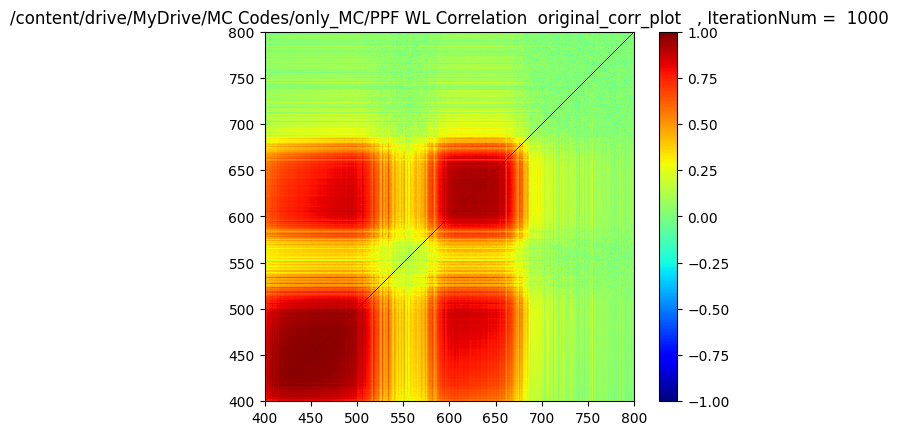

/usr/local/lib/python3.10/dist-packages/xlsxwriter/worksheet.py:1534: UserWarning: Image file 'original_corr_plot.png' not found.
  warn("Image file '%s' not found." % filename)


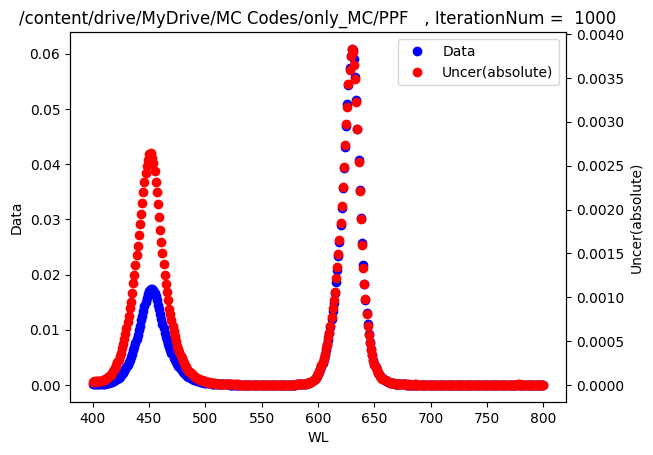

/usr/local/lib/python3.10/dist-packages/xlsxwriter/worksheet.py:1534: UserWarning: Image file 'histogram.png' not found.
  warn("Image file '%s' not found." % filename)


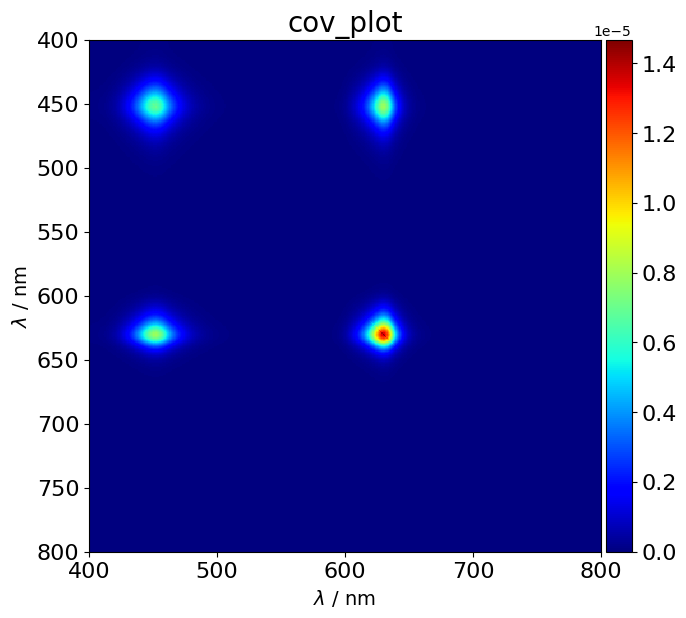

/usr/local/lib/python3.10/dist-packages/xlsxwriter/worksheet.py:1534: UserWarning: Image file 'cov_plot.png' not found.
  warn("Image file '%s' not found." % filename)


In [71]:
    mainMC(drawNumber , input_FileName , modelFunctionName)